<h1>Diagnosing Malaria in a cell</h1>
Classifying them as 'Parasatized' or 'Unparasatized'. This is a binary classification problem, here, we will be dealing with the images of cells. Each image is made of several pixels and every pixel holds a number from 0-255, so we can distribute the image into several pixels as per the resolution and then assign a value from 0-255 to every pixel in it's RGB (Red Green Blue) Layers. We will normalize the values and then consider them. <br> <br>

So basically, an image can be defined by 3 layers, R layer, G layer and B Layer. consider a pixel at position (34,85) in the image, the values in the 3 layers at that position can tell us what color that particular pixel holds. The color of the layer in which this positioned cell has a value closer to '1' is the more dominant color. <br><br>

So the common format to represent an image mathematically is Height, Width and Channel Matrix (3 Channels, R, G and B). Since all the colors lie between Black and White, which corresponds to the values between '0' and '255', which when normalised, corresponds to '0' and '1'.

<h1>Importing necessary libraries</h1>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, Dense, MaxPool2D, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError

<h1>Data Preparation and Splitting</h1>

In [7]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

# Extract the dataset from the list
dataset = dataset[0]

In [8]:

# Define the splits function
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
    DATASET_SIZE = tf.data.experimental.cardinality(dataset).numpy()  # Get dataset size

    train_size = int(TRAIN_RATIO * DATASET_SIZE)
    val_size = int(VAL_RATIO * DATASET_SIZE)

    # First part for training data
    train_data = dataset.take(train_size)

    # Skip the train data, take validation data
    val_test_data = dataset.skip(train_size)
    val_data = val_test_data.take(val_size)

    # Remaining data for testing
    test_data = val_test_data.skip(val_size)

    return train_data, val_data, test_data




In [9]:
# Ratios
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

# Perform the split
train_data, val_data, test_data = splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO)

# Print sample data from splits
print("Train data:", list(train_data.take(1).as_numpy_iterator()))
print("Validation data:", list(val_data.take(1).as_numpy_iterator()))
print("Test data:", list(test_data.take(1).as_numpy_iterator()))

Train data: [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)]
Validation data: [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0,

In [ ]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
dataset_info

tfds.core.DatasetInfo(
    name='malaria',
    full_name='malaria/1.0.0',
    description="""
    The Malaria dataset contains a total of 27,558 cell images with equal instances
    of parasitized and uninfected cells from the thin blood smear slide images of
    segmented cells.
    """,
    homepage='https://lhncbc.nlm.nih.gov/publication/pub9932',
    data_dir='/Users/atharvakulkarni/tensorflow_datasets/malaria/1.0.0',
    file_format=tfrecord,
    download_size=337.08 MiB,
    dataset_size=317.62 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=27558, num_shards=4>,
    },
    citation="""@article{rajaraman2018pre,
      title={Pre-trained convolutional neural networks as feature extractors toward
      improved malaria parasite detection in th

In [ ]:
for data in dataset[0].take(1):
    print(data)

TypeError: '_PrefetchDataset' object is not subscriptable

<h1>Data Visualizing</h1>

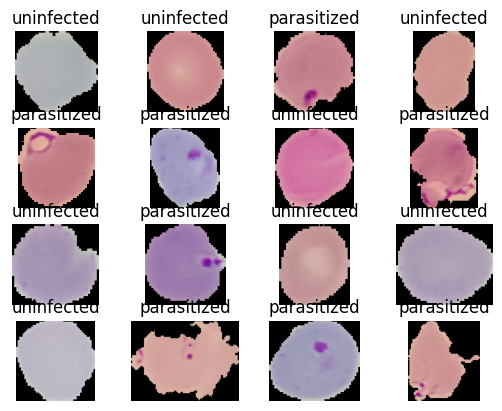

In [10]:
for i, (image, label) in enumerate(train_data.take(16)):
    ax = plt.subplot(4,4,i+1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off') # to turn off the axes

In [ ]:
#if we want to get the feature of a particular cell:
dataset_info.features['label'].int2str(1)

'uninfected'

<h1>Data Preprocessing</h1>

<h2>Task 1: Resizing the images to a particular size</h2>

In [11]:
IM_SIZE = 224

def resize_rescale(image, label):
    image = tf.image.resize(image, (IM_SIZE, IM_SIZE))
    image = image / 255.0  # Normalize the image
    return image, label

train_data = train_data.map(resize_rescale)
val_data = val_data.map(resize_rescale)
test_data = test_data.map(resize_rescale)


In [ ]:
for image, label in train_data.take(1):
    print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(0, shape=(), dtype=int64)


In [ ]:
#we can clearly see that the image size has been changed to (224,224,3) successfully.

In [12]:
train_data = train_data.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [13]:
val_data = val_data.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

<h1>HyperParameters</h1>
<h2>Input Size:</h2>
The input size of the matrix (features assembled in a matrix form)<br>
<h2>Padding:</h2>
The outer layer we add to the input matrix so as to make sure that the corner elements have an impact of final output<br>
<h2>Kernel Size (Filter):</h2>
The window or the matrix of a certain size less than or equal to the input size such that it takes only the neurons of the matrix in its own purview<br>
<h2>Stride:</h2>
The distance by which the Kernel layer should move on the input layer while hovering over it to collect the inputs from the input matrix.


In [ ]:
# It is not necessary that every neuron is connected to the neurons of the previous layer neurons. The NN where only a few neurons
# are connected to a single neuron in the following layer is called as Convolutional Neural Network (CNN).

#Thus, only a few neurons are required to determine the value of the next neuron of the next layer.

In [ ]:
#The kernel size is the filter which hovers over the matrix of the inputs and chooses the selective dimensioned part of it to pass it

#to the neuron of the next layer. Increasing the kernel size results in to the reduction of the output layer (provided the stride is maintained)

#For a lesser kernel size, we can extract more complex information, while, with a larger kernel size, we can extract multiple features.

#Output size = [Wo] = [Wi - (Kernel Size) + 1]

#If the padding is done, we need to add the padding value to the input size

#Thus:
#Output size = [Wo] = [Wi + (Padding) - (Kernel Size) + 1]

# Having a padding value ensures that the corner elements of the input matrix have an impact on out output!

# This is because, the filter will be able to pass through the corners multiple times thus making sure that the corner elements have a
# good impact over the output.

#Addtion of stride leads to less movement of the kernel on the particular cell, thus reduces the amount of information that we extract from
# the inputs.

<h2>Final Formula for calculating the output size of the matrix by considering all the Hyperparametres</h2>
<h3>Wo = (Wi - F + 2P) / S</h3>
Where, <br>
Wo = Size of the output matrix<br>
Wi = Size of the input matrix <br>
F = Kernel Size<br>
P = Padding applied <br>
S = Stride applied<br>

We will be using the architecture below to finally get the flattened layer which can be further applied to our dense networks to get the final output. And instead of 200 we will be having 2 because we are predicting if the cell is 'Parasitic' or 'Uninfected'.

![Screenshot 2024-09-12 at 8.47.59 AM.png](attachment:56958b8a-02a8-4fa5-85c0-ae1ce527a512.png)

The image below shows how the initial features which are visually interpretable are used for feature extraction. Further, the features ahead are visually not interpretable but they focus on more high level features and thus are more inclined towards giving us a classification.

![Screenshot 2024-09-12 at 8.54.20 AM.png](attachment:233bad4d-35fd-4922-951e-11ba3d43ab21.png)

<h1>Model Building</h1>

In [14]:
model = tf.keras.Sequential([

    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 5, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 5, strides = 1, padding = 'valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    Dense(100, activation = 'relu'),
    BatchNormalization(),
    Dense(10, activation = 'relu'),
    BatchNormalization(),
    Dense(1, activation = 'sigmoid')
])

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 220, 220, 6)         │             456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 220, 220, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 110, 110, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 106, 106, 16)        │           2,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 106, 106, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 53, 53, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 44944)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       4,494,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

<h2>Example of Binary Cross Entropy Loss Function</h2>

In [ ]:
y_pred = tf.constant([0,1,0,0.3])
y_true = tf.constant([0.1, 0, 0.8, 1])
bce = tf.keras.losses.CategoricalCrossentropy()
bce(y_true, y_pred)
#We use from_logits = True when we are not sure if the y_pred values are between the range [0,1]

<tf.Tensor: shape=(), dtype=float32, numpy=15.972624>

In [15]:
model.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [16]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [17]:
val_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
test_data

<_MapDataset element_spec=(TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [19]:
history = model.fit(train_data, validation_data = val_data, epochs = 20, verbose = 1)

Epoch 1/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 64s 79ms/step - accuracy: 0.7391 - loss: 0.5053 - val_accuracy: 0.5067 - val_loss: 11.9840
Epoch 2/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 44s 63ms/step - accuracy: 0.7498 - loss: 0.5025 - val_accuracy: 0.6817 - val_loss: 1.9381
Epoch 3/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 88s 71ms/step - accuracy: 0.9141 - loss: 0.2334 - val_accuracy: 0.9343 - val_loss: 0.2367
Epoch 4/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 47s 68ms/step - accuracy: 0.9386 - loss: 0.1759 - val_accuracy: 0.5604 - val_loss: 0.5020
Epoch 5/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 45s 65ms/step - accuracy: 0.9471 - loss: 0.1568 - val_accuracy: 0.8113 - val_loss: 0.3823
Epoch 6/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 43s 62ms/step - accuracy: 0.9513 - loss: 0.1500 - val_accuracy: 0.9114 - val_loss: 0.3585
Epoch 7/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 45s 66ms/step - accuracy: 0.9530 - loss: 0.1410 - val_accuracy: 0.8682 - val_loss: 0.7136
Epoch 8/20
689/689 ━━━━━━━━━━━━━━━━━━━━ 43s 63ms/step - accuracy: 0.9560 - loss: 0.1315 -

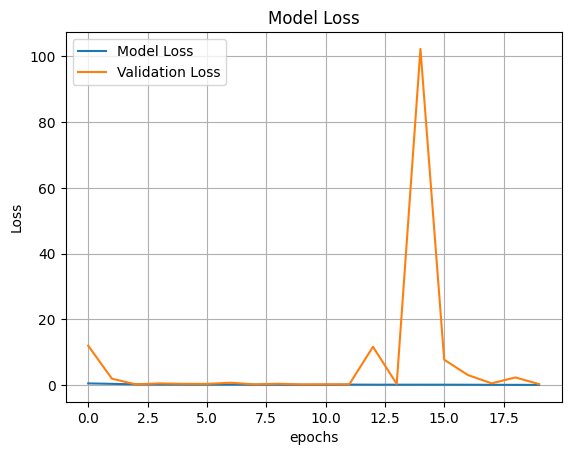

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.legend(['Model Loss', 'Validation Loss'])
plt.grid(True)
plt.show()


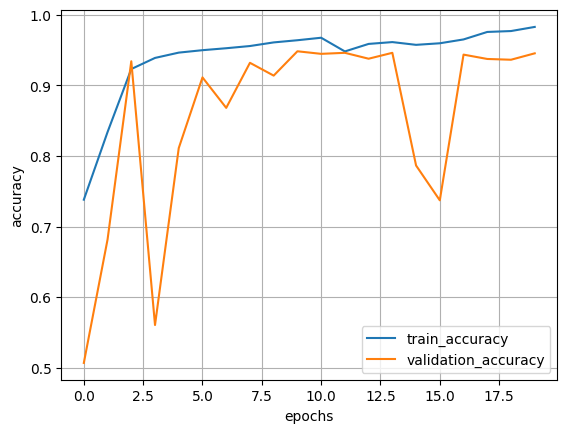

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.grid(True)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train_accuracy', 'validation_accuracy'])
plt.grid(True)
plt.show()

In [32]:
#Now take the test dataset, it has dimensions (224,224,3), we need to get that to (None, 224,224,3);

In [33]:
test_data = test_data.batch(1)

In [34]:
test_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [35]:
model.evaluate(test_data)

2757/2757 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - accuracy: 0.9417 - loss: 0.3558


[0.35210981965065, 0.9405150413513184]

In [36]:
model.predict(test_data.take(1))[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


0.9999379

In [37]:
def isParasitized(x):
  if x<0.5:
    return str('p')
  else:
    return str('U')

In [38]:
isParasitized(model.predict(test_data.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


'U'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


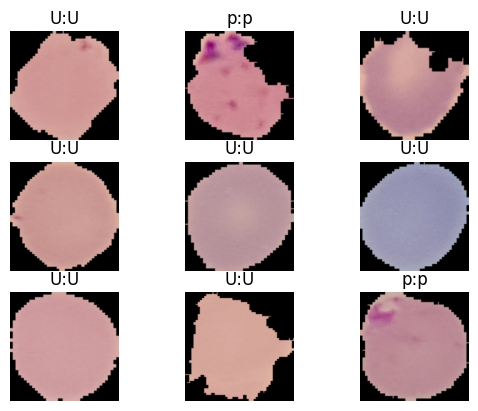

In [41]:
for i, (image,label) in enumerate(test_data.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str(isParasitized(label.numpy()[0])) + ":" + str(isParasitized(model.predict(image)[0][0])))
  plt.axis('off')